# 1. Import Libraries

In [1]:
 
#mandatory libraries
import os
import re
import string
import numpy as np
import pandas as pd

#plotting libraries
import venn
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns


#NLTK libraries  & for data cleaning
import contractions
import nltk
from nltk.tree import Tree
from nltk.corpus import stopwords
from nltk import ne_chunk, pos_tag, word_tokenize
from nltk.stem.wordnet import WordNetLemmatizer
from nltk.stem.snowball import SnowballStemmer
from wordcloud import WordCloud, STOPWORDS

#sk-learn libraries for vectorization and TSNE
from sklearn.manifold import TSNE
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer

#miscellaneous libraries
import warnings
warnings.filterwarnings("ignore")
from tqdm import tqdm
from itertools import combinations 

/var/folders/tw/vlygwkss6vj71vkqq_gzzx6m0000gn/T/ipykernel_70799/2778211595.py:6: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


# 2. Load Dataset

In [2]:
data=pd.read_csv("train.csv")

# 3. Study Dataset
### 3.1 Shape of Dataset

Check shape of dataset

In [3]:

data.shape
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 159571 entries, 0 to 159570
Data columns (total 8 columns):
 #   Column         Non-Null Count   Dtype 
---  ------         --------------   ----- 
 0   id             159571 non-null  object
 1   comment_text   159571 non-null  object
 2   toxic          159571 non-null  int64 
 3   severe_toxic   159571 non-null  int64 
 4   obscene        159571 non-null  int64 
 5   threat         159571 non-null  int64 
 6   insult         159571 non-null  int64 
 7   identity_hate  159571 non-null  int64 
dtypes: int64(6), object(2)
memory usage: 9.7+ MB


### 3.2 Checking the Missing Values in Data-set

In [4]:
data.isnull().values.any() 
data.duplicated().values.any()

False

No missing values in any of the columns

### 3.3 Checking the Duplicate Values in Data-set

In [5]:
data.duplicated().values.any()

False

### 3.4 Basic Statistics

In [6]:
data.describe()

,toxic,severe_toxic,obscene,threat,insult,identity_hate
count,159571.000000,159571.000000,159571.000000,159571.000000,159571.000000,159571.000000
mean,0.095844,0.009996,0.052948,0.002996,0.049364,0.008805
std,0.294379,0.099477,0.223931,0.054650,0.216627,0.093420
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


From the above output, once again it is clear that no values are missing in any of the columns.

Since id and comment_text are text features, no mean, std, 25th, 50th,75th percentiles are caluculated.

Since, only target labels are numeric in our dataset, describe function calculated basic statistics on targets.

### 3.5 Value-Counts on Target Labels Individually


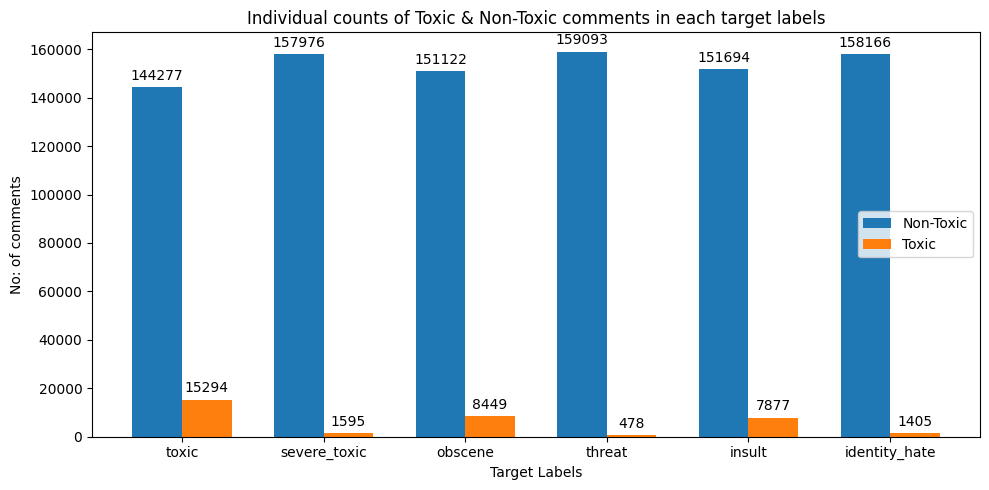

In [7]:
labels = data.columns.values[2:]
class_0=[]
class_1=[]

for i in data.columns.values[2:]:
    vc=data[i].value_counts()
    class_0.append(vc[0])
    class_1.append(vc[1])

x = np.arange(len(labels))  # the label locations
width = 0.35  # the width of the bars

fig, ax = plt.subplots(figsize=(10,5))
rects1 = ax.bar(x - width/2, class_0, width, label='Non-Toxic')
rects2 = ax.bar(x + width/2, class_1, width, label='Toxic')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('No: of comments')
ax.set_xlabel("Target Labels")
ax.set_title('Individual counts of Toxic & Non-Toxic comments in each target labels')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend(loc=7)

ax.bar_label(rects1, padding=3)
ax.bar_label(rects2, padding=3)

ax.bar
fig.tight_layout()

plt.show()

The plot above is the individual counts of class zero & class 1, ie comment is classified as toxic= class 1 and comment is classified as non-toxic= class 0.

From this plot we can understand that the data set is highly imbalanced.

This is pictorial representation of value counts of classes, for each target individually

### 3.6 Corelation between target variables

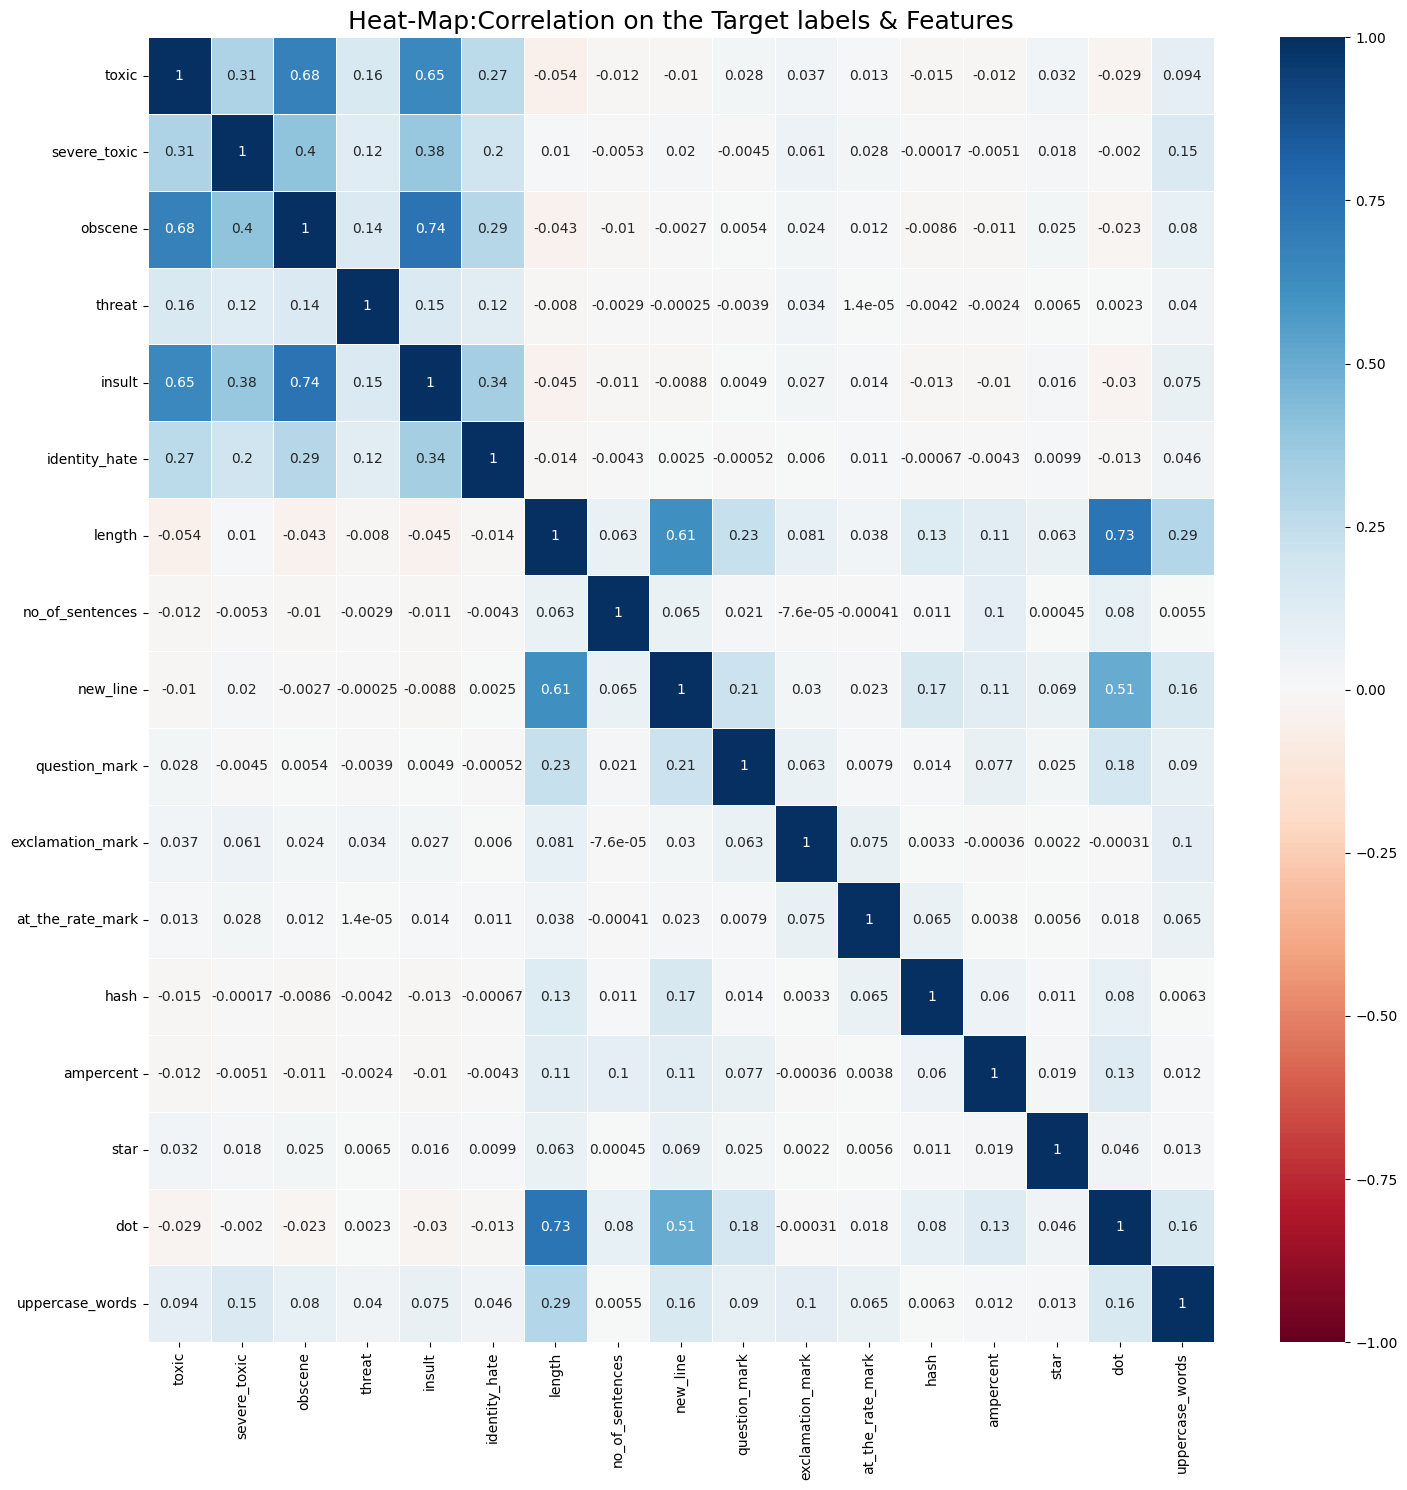

In [8]:
corr_df=data.drop(columns=["id","comment_text"])
corr_df['length']=data['comment_text'].str.len()
corr_df['no_of_sentences']=data['comment_text'].str.split("/n").apply(len)
corr_df['new_line'] = data['comment_text'].str.count('\n')
corr_df['question_mark'] = data['comment_text'].str.count('\?')
corr_df['exclamation_mark'] = data['comment_text'].str.count('!')
corr_df['at_the_rate_mark'] = data['comment_text'].str.count('@')
corr_df['hash'] = data['comment_text'].str.count('#')
corr_df['ampercent'] = data['comment_text'].str.count('&')
corr_df['star']= data['comment_text'].str.count('\*')
corr_df['dot'] = data['comment_text'].str.count('\.')
corr_df['uppercase_words'] = data['comment_text'].str.split().apply(lambda x: sum(map(str.isupper, x)))

correlation=corr_df.corr()

plt.figure(figsize=(15,15))
sns.heatmap(correlation,vmin=-1,cmap='RdBu',annot=True,linewidths=.5)
plt.title("Heat-Map:Correlation on the Target labels & Features",fontsize=18)
plt.tight_layout()

The correlation plot show that there is good relation between the labels toxic and insult, toxic and obscene, and obscene and insult. So, in the presence of one of the labels in the pairs for a comment, it is likely that the comment will also have the other label.


# 5. Preprocessing

Pre-process the data, before feeding to the model. Since our input is text/string type, let's investigate and retain only useful information in the input text.

In [9]:

indices=np.random.randint(data.shape[0],size=5)

for i in indices:
    print(i,"--->",data['comment_text'].values[i])

89603 ---> Once again your misinformation just amazes me. Their is nothing on the webs site the designinates any official meighbourhood what so ever.A census track is not a neighbouhood, it is not uncommon to have several tracks in a neighbourhood. An empowerment zone  is not an neighborhood, The Empowerment Zone (EZ) is a federally funded community development and economic revitalization initiative. The EZ designation provides localities with a federal grant and a set of tax and financing incentives to improve public safety, advance human development, create a welcoming environment and invigorate commerceThey are based upon census tracks, and like sensus tracks it is not uncommon for an Empowerment Zone to encompass several neighborhoods, either in whole or in part. Same goes for Enterprise Zones, Wards, Council districts, zip codes, no of which are specific neighborhoods nor do they desiginate official neighborhoods. The only information that is used id the planning distrctis, which 

From above random samples, we can understand there are so many line breaks ("\n") and punctation marks,and some upper cased words,stop words,Decontractions, HTML tags, links etc. So lets clean all those unncessary wor

### 5.1 Preprocessing Functions


In [10]:
def convert_to_lower_case(text):

    """function to convert the input text to lower case"""
    
    return text.lower()
def remove_escape_char(text):

    """function to remove newline (\n),
    tab(\t) and slashes (/ , \) from the input text"""

    return re.sub(r"[\n\t\\\/]"," ",text, flags=re.MULTILINE)
def remove_html_tags(text):

    """function to remove html tags (< >) and its content 
    from the input text"""

    return re.sub(r"<.*>"," ",text, flags=re.MULTILINE)
def remove_links(text):
    """function to remove any kind of links with no 
    html tags"""

    text= re.sub(r"http\S+"," ",text, flags=re.MULTILINE)

    return re.sub(r"www\S+"," ",text, flags=re.MULTILINE)
def remove_digits(text):

    """function to remove digits from the input text"""

    return re.sub(r'\d'," ",text, flags=re.MULTILINE)
def remove_punctuation(text):

    """function to remove punctuation marks from the input text"""

    for i in string.punctuation:
        text = text.replace(i," ")

    return text      
def chuncking(text):

    """function to perform chucking, which is also referred as shallow parsing.
    This is useful in determing the parts of speech of a given text and adds more
    structure to the input data ."""

    """In this function, we use NLTK library to perform chuncking and if a 
    particular label is PERSON names, we remove that, and names of Geo-graphic
    
    ares are retained by adding _ in its words.ex-New_York"""


    chunks_data=[]
    chunks_data=(list(ne_chunk(pos_tag(word_tokenize(text)))))
    for label in chunks_data:
        if type(label)==Tree:
            if label.label() == "GPE":
                a = label.leaves()
                if len(a)>1:
                    gpe = "_".join([term for term,pos in a])
                    text = re.sub(rf'{a[1][0]}',gpe,text, flags=re.MULTILINE)
                    text = re.sub(rf'\b{a[0][0]}\b'," ",text, flags=re.MULTILINE)
            if label.label()=="PERSON":      
                for term,pog in label.leaves():
                    text = re.sub(re.escape(term)," ",text, flags=re.MULTILINE)
    return text
def keep_alpha_and_underscore(text):

    """function to keep only aphabets and _ underscore, as we 
    added it in the chunking for geographic locations."""
    
    return re.sub(r"[^a-zA-Z_]"," ",text,flags=re.MULTILINE)
def remove_extra_spaces_if_any(text):

    """function to remove extra spaces if any after all the pre-preocessing"""
    
    return re.sub(r" {2,}", " ", text, flags=re.MULTILINE)
#on close observation of toxic comments, In some of the bad comments, words in 
#bad words characters are repeated. say for example...
#the word "shit" is written as SSSSHHHHHHHHIIIIIIIIIIITTTTTT
#but the base word is "shit", in order to increase model performance
# i am adding this.

def remove_repeated_characters(text):

    """function to remove repeated characters if any from the input text"""

    """for example CAAAAASSSSSSEEEEE SSSSTTTTTUUUUUUDDDDYYYYYY gives CASE STUDY"""

    return re.sub(r"(\w)(\1{2,})","\\1",text,flags=re.MULTILINE)
#sample check
remove_repeated_characters("CAAAAASSSSSSEEEEE SSSSTTTTTUUUUUUDDDDYYYYYY")
'CASE STUDY'
def remove_words_lesth2(text):
    """function to remove words with length less than 2"""

    text = re.sub(r'\b\w{1,2}\b'," ",text)
    
    return text
def decontraction(text):

    """function to handle contraction errors"""
    res=""
    for word in text.split():
        try:
            con_text=contractions.fix(word)
            if con_text.lower() is word.lower():
                res=res+word+" "
            else:
                res=res+con_text+" "
        
        except:
            con_text=contractions.fix(word.lower())
            if con_text.lower() is word.lower():
                res=res+word+" "
            else:
                res=res+con_text+" "
    return res.strip()

### 5.2 Stop-Words

Stop words means, which doesn't carry any importance in classification task. ie., words which are most occuring in the data-set and doesnt carry any importance in classifying either a positive/negative class. words like the, i , he, she, we, our, his, her, it, a , an, in, of, one, two, three, four, etc

In [11]:
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')
nltk.download('maxent_ne_chunker')
nltk.download('words')
nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Error loading punkt: <urlopen error [Errno 8] nodename nor
[nltk_data]     servname provided, or not known>
[nltk_data] Error loading averaged_perceptron_tagger: <urlopen error
[nltk_data]     [Errno 8] nodename nor servname provided, or not
[nltk_data]     known>
[nltk_data] Error loading maxent_ne_chunker: <urlopen error [Errno 8]
[nltk_data]     nodename nor servname provided, or not known>
[nltk_data] Error loading words: <urlopen error [Errno 8] nodename nor
[nltk_data]     servname provided, or not known>
[nltk_data] Error loading stopwords: <urlopen error [Errno 8] nodename
[nltk_data]     nor servname provided, or not known>
[nltk_data] Error loading wordnet: <urlopen error [Errno 8] nodename
[nltk_data]     nor servname provided, or not known>


False

Stop Words in NLTK

In [12]:
stop_words=stopwords.words('english')
display_length=10

for i in range(int(np.ceil(len(stop_words)/display_length))):
    print(stop_words[i*display_length:(i+1)*display_length])

['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're"]
["you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his']
['himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself']
['they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this']
['that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be']
['been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing']
['a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until']
['while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into']
['through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down']
['in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once']
['here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each']
['few', 'more', 'most', 'other', 'some', 'such', 'no', 'nor', 'not', 'only']
['own', 'same', 'so

Stop words in Word Cloud Library

In [13]:
display_length=10
word_cloud_stp_wrds=list(STOPWORDS)
for i in range(int(np.ceil(len(list(word_cloud_stp_wrds))/display_length))):
    print(word_cloud_stp_wrds[i*display_length:(i+1)*display_length])

["isn't", 'than', "they're", 'my', 'himself', 'www', 'should', 'her', 'so', 'ought']
['under', 'since', "it's", "shouldn't", 'yours', 'both', 'having', 'not', 'same', 'that']
['about', 'he', 'through', 'where', "didn't", "she's", 'ours', 'herself', "they'd", "you'll"]
['cannot', 'hers', 'how', 'would', 'doing', 'on', "let's", "where's", 'off', 'the']
['when', 'its', 'r', "he's", "you've", "who's", "shan't", 'because', "here's", 'k']
['no', 'shall', 'any', 'for', 'she', 'can', 'after', 'hence', 'up', "why's"]
["we're", 'could', "when's", 'been', 'ourselves', 'down', 'only', 'also', "what's", 'with']
['while', 'why', 'your', 'therefore', 'or', 'theirs', "weren't", 'here', 'http', 'a']
["wouldn't", 'i', 'those', "hadn't", 'out', 'above', 'all', 'being', "i'd", 'are']
['as', 'get', 'has', 'just', "he'll", "she'd", "don't", "i've", 'there', 'had']
['itself', 'of', 'our', 'themselves', 'an', 'else', 'myself', "hasn't", 'which', 'until']
['against', "we'd", 'before', "wasn't", "she'll", 'your

Combine all the stop words from both NLTK & Word Cloud libraries, along with some custom words

In [14]:
final_stop_words=list(STOPWORDS.union(set(stop_words)))
final_stop_words.extend(["mr","mrs","miss",
                        "one","two","three","four","five",
                        "six","seven","eight","nine","ten",
                        "us","also","dont","cant","any","can","along",
                        "among","during","anyone",
                         "a","b","c","d","e","f","g","h","i","j","k","l","m",
                         "n","o","p","q","r","s","t","u","v","w","x","y","z","hi","hello","hey","ok",
                         "okay","lol","rofl","hola","let","may","etc"])

display_length=10

for i in range(int(np.ceil(len(final_stop_words)/display_length))):
    print(final_stop_words[i*display_length:(i+1)*display_length])

["isn't", 'than', 'my', 'www', 'ought', 'yours', "it's", "shouldn't", 'both', 'having']
['same', 'he', 'through', "didn't", 'aren', 'now', 'ma', 'cannot', 'would', 'doing']
['on', "where's", 'off', 'the', 'o', 'when', 'its', 'r', "you've", "who's"]
["shan't", 're', 'no', 'shall', 'any', 'she', 'up', 'hence', "we're", 'could']
["when's", 'been', 'ourselves', 'also', 'wasn', 'didn', 'why', 'your', 'therefore', 'theirs']
['weren', 'http', 'a', 'i', 'those', 'above', 'being', 'as', 'has', 'just']
["she'd", 'itself', 'our', 'themselves', 'an', 'until', 'against', "we'd", "wasn't", "she'll"]
['yourselves', 'if', 'who', 't', 'ever', "we'll", 'd', 'over', 'this', "needn't"]
['does', 'was', "won't", 'however', 'below', 'further', 'his', "mustn't", 'more', "you'd"]
['again', "they've", 'me', "that's", 'whom', 'needn', 'each', 'most', 'these', "they'll"]
["i'll", 'is', 'nor', 'have', 'such', 'some', "mightn't", "aren't", "i'm", 'were']
['doesn', 'in', 'it', 'between', 'am', 'by', 'own', "they're"

### 5.3 Lemmatization 

Lemmatization is the process of grouping different forms of words in to a single word. Lemmatization and stemming are similar. But Lemmatization brings the meaning to the context and morphological analysis.

For Example

Good--> Better--> Best all are based on the word "Good"

Dogs--> Dog

Apples--> Apple

In [15]:
lemmatiser = WordNetLemmatizer()

Defining the one-step preprocessing function to perform all the different pre-processing steps noted above.

In [16]:
def preprocess(text):

    preprocessed_text = []

    for each_text in tqdm(text):

        result=remove_links(each_text)
        result=remove_html_tags(result)
        result=remove_escape_char(result)        
        result=remove_digits(result)
        result=decontraction(result)
        result=remove_punctuation(result)
        result=chuncking(result)
        result=convert_to_lower_case(result)
        result = ' '.join(non_stop_word for non_stop_word in result.split() if non_stop_word not in final_stop_words)
        result=keep_alpha_and_underscore(result)
        result=remove_extra_spaces_if_any(result)
        result=remove_repeated_characters(result)
        result=remove_words_lesth2(result)
        result=' '.join(lemmatiser.lemmatize(word,pos="v") for word in result.split())
        preprocessed_text.append(result.strip())
        
    return preprocessed_text

In [17]:
from ipywidgets import FloatProgress
indices=np.random.randint(len(data['comment_text'].values),size=5)
indices= np.append(indices,999)

for i in indices:
    print(i," - Original Text ---> ",data['comment_text'].values[i])
    print(i," - Processed Text ---> ",preprocess([data['comment_text'].values[i]]))

29181  - Original Text --->  Hey Sas87, the article of the 20th has a photo of the testers at his house. I believe that they went first at the pool and then at his house. The point is not where they went, but that they did went to where ever Ian told them that he will be, and he was not there. That by it self is unprofessional and against ASADA regulations, as stated from all the articles quoted from the ASADA website. You are a pro, you give ASADA a 3 month calendar to where you will be each day so you can be test. If you are picked for a test, you have to be there within an hour or tell ASADA to wait for a bit more cause you are stack at the lights!!! When our top cricketers announced that they resign, they did it in full view without hiding behind curtains. Ian is responsible for ruining his pro image, not the media. I only want the documented facts to be available and I see no reason why we should not duplicate what all the newspapers had on their front page those days. Are we all 

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.00it/s]


29181  - Processed Text --->  ['sas article photo testers house believe go first pool house point go go tell self unprofessional asada regulations state article quote asada website pro give asada month calendar day test pick test within hour tell asada wait bite stack light top cricketers announce resign full view without hide behind curtain responsible ruin pro image media want document facts available see reason duplicate newspapers front page days suffer selective memory sas although give put main page still thing appropriate']
140836  - Original Text --->  Internet Explorer 8. I'm working on getting the page deleted.  (talk·contribs·)


100%|██████████| 1/1 [00:00<00:00, 356.11it/s]


140836  - Processed Text --->  ['internet explorer work get page delete talk contribs']
157474  - Original Text --->  "
 Then expect a WP:BOOMERANG unless you or someone else proves your WP:ASPERSIONS.  "


100%|██████████| 1/1 [00:00<00:00, 281.59it/s]


157474  - Processed Text --->  ['expect boomerang unless someone prove aspersions']
72156  - Original Text --->  thank you very much 

Thanks for your welcome and your help! )  01:21, 16 Oct 2004 (UTC)Jeb


100%|██████████| 1/1 [00:00<00:00, 264.89it/s]


72156  - Processed Text --->  ['thank much thank welcome help']
86697  - Original Text --->  That was me  I got pulled away for a minute en route here.  I'm just not confident it's as inauthentic as posited.  But if a case can be made that it is, that's another matter.


100%|██████████| 1/1 [00:00<00:00, 142.69it/s]


86697  - Processed Text --->  ['get pull away minute route confident inauthentic posit case make another matter']
999  - Original Text --->  this title should redirect to Altona, Hamburg. I w'd change it but at the moment there are too many links for me to bother.


100%|██████████| 1/1 [00:00<00:00, 213.30it/s]

999  - Processed Text --->  ['title redirect change moment many link bother']


### 5.4 Perform the pre-processing on all the comments in the data-set

In [18]:
# preprocessed_data = preprocess(data['comment_text'].values)

Create preprocessed data csv

In [19]:

# clean_data=data.drop(columns=["id"])
# clean_data['comment_text']=preprocessed_data
# clean_data.to_csv("pre_processed_data.csv", header=True, index=False)

# 6. Featurization 

In this section, let us convert text features into vectors ie vectorization. In order to avoid data leackage, let's split the whole data set into train and test data sets and then apply the vectorization.

In [20]:
clean_data=pd.read_csv("pre_processed_data.csv")

### 6.1 Clean empty comments

In [21]:
clean_data.isnull().values.any()

True

Check random sample for null comments

In [22]:
index=clean_data[clean_data['comment_text'].isnull()].index
sample=np.random.choice(index,5)

for i in sample:
    print(i,"- index data before pre-processing-->",data['comment_text'].values[i])
    print(i,"- index data after pre-processing-->",clean_data['comment_text'].values[i])
    print("="*100)

124886 - index data before pre-processing--> Fidel Castro =/= Hitler
124886 - index data after pre-processing--> nan
47072 - index data before pre-processing--> and then 70.8.194.249
47072 - index data after pre-processing--> nan
42601 - index data before pre-processing--> "Shinobi My Contribs "
42601 - index data after pre-processing--> nan
129763 - index data before pre-processing--> Talk Archive 5
Talk Archive 6
129763 - index data after pre-processing--> nan
120025 - index data before pre-processing--> Jeannette Belliveau
120025 - index data after pre-processing--> nan


Most of the comments contains purely numbers, stop-words and links. In pre-processing all these unwanted data has been cleaned and no data exists in that comments.that is why we have nan/nulls in the cleaned data

In [23]:
clean_data.dropna(inplace=True)
clean_data.isnull().values.any()

False

In [24]:
# clean_data.to_csv("pre_processed_data_no_nan.csv",header=True, index=False)

In [25]:
# clean_data=pd.read_csv("pre_processed_data_no_nan.csv")

In [26]:
clean_data.shape

(159190, 7)

In [27]:
clean_data.sample(3)

,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
101638,listen every forum mod admin real life probabl...,1,0,0,0,0,0
15471,thank contribute thank time effort contribute ...,0,0,0,0,0,0
71215,guess give top speed production model record s...,0,0,0,0,0,0


### 6.2 Split Dataset

In [28]:
X=clean_data['comment_text']
y=clean_data.drop(columns=['comment_text'])

In [29]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, 
                                        random_state=42, shuffle=True)

In [30]:
print("Shape of X-Train",X_train.shape)
print("Shape of X-Test",X_test.shape)
print("Shape of y-Train",y_train.shape)
print("Shape of y-Test",y_test.shape)

Shape of X-Train (111433,)
Shape of X-Test (47757,)
Shape of y-Train (111433, 6)
Shape of y-Test (47757, 6)


In [31]:
def change_y(data):

    """"function to convert multiple y labels as single y label"""
    #this is done to plot T-SNE
    res=[]
    for row in data:
        if (sum(row)==0):
            res.append(0)
        else:
            res.append(1)
    return np.array(res)

In [32]:
y_train_tsne=change_y(y_train.values)
y_test_tsne=change_y(y_test.values)
#converting multi y label to single y label
print("Shape of y-Train",y_train_tsne.shape)
print("Shape of y-Test",y_test_tsne.shape)

Shape of y-Train (111433,)
Shape of y-Test (47757,)


# 6.2 Vectorization using TF-IDF

Convert text features into numerical representation. We have various featurizing techniques/algorthms to acheive the same. Here we are using TF-IDF.


#### Bigrams

In [33]:
#Vectorizing essay feature (text) with TF-IDF

vectorizer = TfidfVectorizer(min_df=10,max_features=10000,ngram_range=(2,2),stop_words=final_stop_words)

vectorizer.fit(X_train.values)

# test datacorpus need to be transformed using train vocabulary
X_train_tfidf_bi = vectorizer.transform(X_train.values)

X_test_tfidf_bi = vectorizer.transform(X_test.values)

In [34]:
# #finding the top TF-IDF values/words per class with bi-grams data.

# top_tf_idf_val=[]
# for col in tqdm(y_train.columns):
#     index=y_train[y_train[col]==1].index
#     filtered_data=X_train.loc[index]
#     vec_data=vectorizer.transform(filtered_data)
#     vec_data=vec_data.A

#     #finding the indices of top TF-IDF values across the output

#     indices=np.dstack(np.unravel_index(np.argsort(vec_data.ravel()), vec_data.shape))[0][::-1]
#     feat=vectorizer.get_feature_names_out()
#     avg_tf_idf_scores=dict()

    
#     for index in indices:
#         if feat[index[1]] in avg_tf_idf_scores:
#             value=avg_tf_idf_scores[feat[index[1]]]
#             value.append(vec_data[index[0]][index[1]])
#             avg_tf_idf_scores[feat[index[1]]]=value
#         else:
#             avg_tf_idf_scores[feat[index[1]]]=[vec_data[index[0]][index[1]]]

#     # TF-IDF value is not same for the same word. as it is depends on 
#     #TF value and IDF value
#     #TF value will change based on the input. so finding average TF-IDF value

#     for key in avg_tf_idf_scores:

#         value=np.array(avg_tf_idf_scores[key])
#         avg_tf_idf_scores[key]= np.mean(value)

#     avg_tf_idf_scores={k: v for k, v in sorted(avg_tf_idf_scores.items(),
#                                     key=lambda item: item[1],reverse=True)}

#     top_tf_idf_val.append((list(avg_tf_idf_scores.keys()),list(avg_tf_idf_scores.values())))

In [35]:
# #Plotting the average TF-IDF Value with Uni-gram Per class
# fig, axs = plt.subplots(2,3,figsize=(18,8))
# fig.suptitle("Average TF-IDF Values with Unigrams Per Class",fontsize=24)
# axs=axs.flatten()
# for data,ax,col in zip(top_tf_idf_val,axs,y_train.columns):
#     words=data[0][:10]
#     avg_tf_idf_value=data[1][:10]    
#     rects1 = ax.bar(words, avg_tf_idf_value)
#     ax.set_ylabel('Average TF-IDF Value')
#     ax.set_xlabel("Word")
#     ax.set_title('Average TF-IDF Values in Class-'+str(col))
# fig.tight_layout()
# plt.show()

The above figure is the average TF-IDF values on uni-gram data.

In [36]:
from skmultilearn.problem_transform import BinaryRelevance
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB

# Logistic Regression
lr_clf = BinaryRelevance(LogisticRegression( solver='liblinear'))
lr_clf.fit(train_tfidf, y_train)

#naive bayes
nb_clf = BinaryRelevance(MultinomialNB())
nb_clf.fit(train_tfidf, y_train)

# evaluation
lr_eval = eval_fun_br(x_test=test_tfidf, y_test=y_test, classifier=lr_clf)
nb_eval = eval_fun_br(x_test=test_tfidf, y_test=y_test, classifier=nb_clf)

As our data set is highly imbalanced and we have high Non-Toxic comments than Toxic comments.

Above is the T-SNE for the Uni-gram data and the Toxic and Non Toxic comments grouped with some overlapping.

And also Non Toxic clusters having Toxic points at the random

Different Perpelexity values gave more or less the similar results